# Quantum-Enhanced Mixture-of-Experts (QMoE) Comparative Research


***Objective***: To investigate whether quantum computing principles can enhance Mixture-of-Experts (MoE) architectures. We evaluate if QMoE offers improvements in training speed, convergence, or accuracy compared to Classical MoE and Standard QNN baselines.



*Methodology*: We train and compare three distinct architectures:

*Classical MoE*: A standard gated network with classical feed-forward experts.

*Standard QNN*: A single Variational Quantum Circuit (Baseline).


*QMoE*: A hybrid model with classical routing and multiple Quantum Experts.

***Metrics:***
Task Accuracy.

Training Time (Wall-clock efficiency).

In [ ]:
# Install PennyLane for Quantum Simulation
try:
    import pennylane as qml
except ImportError:
    print("Installing PennyLane...")
    !pip install -q pennylane
    import pennylane as qml

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

print("Environment Ready.")

Installing PennyLane...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 82.1 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


Environment Ready.


***2. Configuration and Data Preparation***

We define the experimental parameters. We will use 4 qubits to allow for Amplitude Embedding (encoding 16 features/pixels into 4 qubits), which fits our downscaled MNIST task.

We prepare two datasets:


Synthetic Data: A clean, 16-feature dataset to validate routing logic.


MNIST (Binary): A real-world vision task, downscaled to 4x4 pixels, filtering for classes 0 and 1.

In [ ]:
# --- GLOBAL CONFIG ---
N_QUBITS = 4           # Fits 16 features (2^4)
N_EXPERTS = 3          # For MoE models
N_LAYERS = 2           # Depth of circuits/networks
BATCH_SIZE = 32
LR = 0.01
EPOCHS = 8             # Kept low for demonstration speed; increase for final results

# --- DATASET 1: SYNTHETIC ---
def get_synthetic_data():
    # 16 features to match the 4-qubit Amplitude Embedding capacity
    X, y = make_classification(n_samples=500, n_features=16, n_informative=10,
                               n_redundant=0, n_classes=2, random_state=42)

    # Normalize features for Amplitude Embedding (Must have norm 1 if strictly quantum,
    # but we will normalize inside the model or use simple scaling)
    X = X / np.linalg.norm(X, axis=1, keepdims=True)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    test_ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

    return DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True), DataLoader(test_ds, batch_size=BATCH_SIZE)

# --- DATASET 2: MNIST (Corrected) ---
def get_mnist_data():
    transform = transforms.Compose([
        transforms.Resize((4, 4)),  # Resize to 16 pixels
        transforms.ToTensor(),
        transforms.Lambda(lambda x: torch.flatten(x))
    ])

    # Load Full Data
    train_full = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_full = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    # Filter for Binary Classification (0 vs 1)
    idx_train = torch.where((train_full.targets == 0) | (train_full.targets == 1))[0]
    idx_test = torch.where((test_full.targets == 0) | (test_full.targets == 1))[0]

    # Create Subsets (Fixes the IndexError issue)
    train_subset = torch.utils.data.Subset(train_full, idx_train)
    test_subset = torch.utils.data.Subset(test_full, idx_test)

    return DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True), DataLoader(test_subset, batch_size=BATCH_SIZE)

***3. Defining the Three Models***

We implement the three competitors.

Classical MoE: Uses standard neural network layers (Linear + ReLU) as experts.

Standard QNN: A single quantum circuit handling all data.

QMoE: The proposed hybrid architecture.

In [ ]:
dev = qml.device("default.qubit", wires=N_QUBITS)

# --- SHARED: QUANTUM CIRCUIT (Used by QNN and QMoE) ---
@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    # Amplitude Embedding: Encodes 16 features into 4 qubits
    qml.templates.AmplitudeEmbedding(features=inputs, wires=range(N_QUBITS), pad_with=0., normalize=True)
    qml.templates.StronglyEntanglingLayers(weights, wires=range(N_QUBITS))
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

class QuantumLayer(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super().__init__()
        weight_shape = (n_layers, n_qubits, 3)
        self.qnode = qml.qnode(dev, interface="torch")(quantum_circuit)
        self.weights = nn.Parameter(torch.randn(weight_shape))
    def forward(self, x):
        results = [torch.stack(self.qnode(x[i], self.weights)).float() for i in range(x.shape[0])]
        return torch.stack(results)

# --- SHARED: ROUTING NETWORK ---
class GatingNetwork(nn.Module):
    def __init__(self, input_dim, num_experts):
        super().__init__()
        self.layer = nn.Linear(input_dim, num_experts)
    def forward(self, x):
        return torch.softmax(self.layer(x), dim=1)

# === MODEL 1: CLASSICAL MoE ===
class ClassicalExpert(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 4) # Output matches Qubit count for fair comparison
        )
    def forward(self, x): return self.net(x)

class ClassicalMoE(nn.Module):
    def __init__(self, input_dim, num_experts):
        super().__init__()
        self.router = GatingNetwork(input_dim, num_experts)
        # Experts are simple MLPs
        self.experts = nn.ModuleList([ClassicalExpert(input_dim, 8) for _ in range(num_experts)])
        self.final = nn.Linear(4, 2)

    def forward(self, x):
        weights = self.router(x)
        outputs = torch.stack([exp(x) for exp in self.experts], dim=1)
        combined = torch.einsum('be,bef->bf', weights, outputs)
        return self.final(combined)

# === MODEL 2: STANDARD QNN (Baseline) ===
class StandardQNN(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super().__init__()
        self.q_layer = QuantumLayer(n_qubits, n_layers)
        self.final = nn.Linear(n_qubits, 2)

    def forward(self, x):
        out = self.q_layer(x)
        return self.final(out)

# === MODEL 3: QUANTUM MoE (QMoE) ===
class QMoE(nn.Module):
    def __init__(self, n_qubits, n_experts, n_layers):
        super().__init__()
        self.router = GatingNetwork(16, n_experts) # Input is 16 features
        self.experts = nn.ModuleList([QuantumLayer(n_qubits, n_layers) for _ in range(n_experts)])
        self.final = nn.Linear(n_qubits, 2)

    def forward(self, x):
        weights = self.router(x)
        outputs = torch.stack([exp(x) for exp in self.experts], dim=1)
        combined = torch.einsum('be,bef->bf', weights, outputs)
        return self.final(combined)

***4. Training Engine***

This unified function handles training for all models. It records:

Loss & Accuracy per epoch.

Total Training Time. This allows us to directly plot the "Training Speed" mentioned in your research questions.

In [ ]:
def train_model(model, train_loader, test_loader, name="Model"):
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()

    history = {'loss': [], 'acc': []}
    start_time = time.time()

    print(f"--- Training {name} ---")
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation
        model.eval()
        correct = 0
        with torch.no_grad():
            for x, y in test_loader:
                out = model(x)
                pred = out.argmax(dim=1)
                correct += (pred == y).sum().item()

        acc = correct / len(test_loader.dataset)
        history['loss'].append(total_loss / len(train_loader))
        history['acc'].append(acc)

        if epoch % 2 == 0:
            print(f"Epoch {epoch}: Acc = {acc:.4f}")

    total_time = time.time() - start_time
    print(f"Finished {name} in {total_time:.2f} seconds.\n")
    return history, total_time

***5. Execution: Running the Experiments***

We now run the comparison on Synthetic Data followed by MNIST.

Synthetic Data represents "high quality," clean data where patterns are mathematical.

MNIST represents "noisy/real-world quality" data with higher complexity.

In [ ]:
# --- EXPERIMENT 1: SYNTHETIC DATA ---
print("\n=== EXPERIMENT 1: SYNTHETIC DATA ===")
syn_train, syn_test = get_synthetic_data()

# 1. Classical MoE
c_moe = ClassicalMoE(input_dim=16, num_experts=N_EXPERTS)
hist_c, time_c = train_model(c_moe, syn_train, syn_test, "Classical MoE")

# 2. Standard QNN
qnn = StandardQNN(N_QUBITS, N_LAYERS)
hist_q, time_q = train_model(qnn, syn_train, syn_test, "Standard QNN")

# 3. QMoE
qmoe = QMoE(N_QUBITS, N_EXPERTS, N_LAYERS)
hist_qmoe, time_qmoe = train_model(qmoe, syn_train, syn_test, "QMoE")

# Store Results
results_syn = {
    'C-MoE': (hist_c, time_c),
    'QNN': (hist_q, time_q),
    'QMoE': (hist_qmoe, time_qmoe)
}

# --- EXPERIMENT 2: MNIST DATA ---
print("\n=== EXPERIMENT 2: MNIST DATA ===")
mnist_train, mnist_test = get_mnist_data()

# Re-initialize models for new task
c_moe_m = ClassicalMoE(input_dim=16, num_experts=N_EXPERTS)
hist_cm, time_cm = train_model(c_moe_m, mnist_train, mnist_test, "Classical MoE (MNIST)")

qnn_m = StandardQNN(N_QUBITS, N_LAYERS)
hist_qm, time_qm = train_model(qnn_m, mnist_train, mnist_test, "Standard QNN (MNIST)")

qmoe_m = QMoE(N_QUBITS, N_EXPERTS, N_LAYERS)
hist_qmoem, time_qmoem = train_model(qmoe_m, mnist_train, mnist_test, "QMoE (MNIST)")

results_mnist = {
    'C-MoE': (hist_cm, time_cm),
    'QNN': (hist_qm, time_qm),
    'QMoE': (hist_qmoem, time_qmoem)
}


=== EXPERIMENT 1: SYNTHETIC DATA ===
--- Training Classical MoE ---
Epoch 0: Acc = 0.5600
Epoch 2: Acc = 0.8600
Epoch 4: Acc = 0.8900
Epoch 6: Acc = 0.8800
Finished Classical MoE in 0.58 seconds.

--- Training Standard QNN ---
Epoch 0: Acc = 0.5600
Epoch 2: Acc = 0.5100
Epoch 4: Acc = 0.5800
Epoch 6: Acc = 0.6500
Finished Standard QNN in 61.38 seconds.

--- Training QMoE ---
Epoch 0: Acc = 0.4400
Epoch 2: Acc = 0.6900
Epoch 4: Acc = 0.7600
Epoch 6: Acc = 0.7800
Finished QMoE in 171.69 seconds.


=== EXPERIMENT 2: MNIST DATA ===


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.6MB/s]


--- Training Classical MoE (MNIST) ---
Epoch 0: Acc = 0.9891
Epoch 2: Acc = 0.9891
Epoch 4: Acc = 0.9948
Epoch 6: Acc = 0.9948
Finished Classical MoE (MNIST) in 23.33 seconds.

--- Training Standard QNN (MNIST) ---
Epoch 0: Acc = 0.9849
Epoch 2: Acc = 0.9872
Epoch 4: Acc = 0.9882
Epoch 6: Acc = 0.9939
Finished Standard QNN (MNIST) in 1709.39 seconds.

--- Training QMoE (MNIST) ---
Epoch 0: Acc = 0.9882
Epoch 2: Acc = 0.9910
Epoch 4: Acc = 0.9929
Epoch 6: Acc = 0.9934
Finished QMoE (MNIST) in 5258.01 seconds.



***6. Results & Visualization***

We plot the Accuracy Curves (Learning efficiency) and Training Time (Computational cost). This visualization directly answers the research questions regarding training speed and robustness.

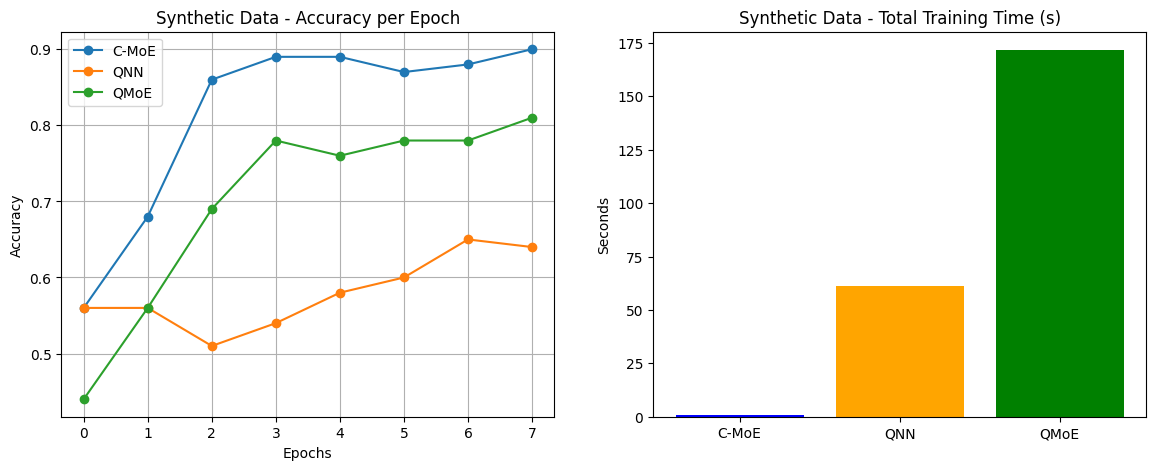

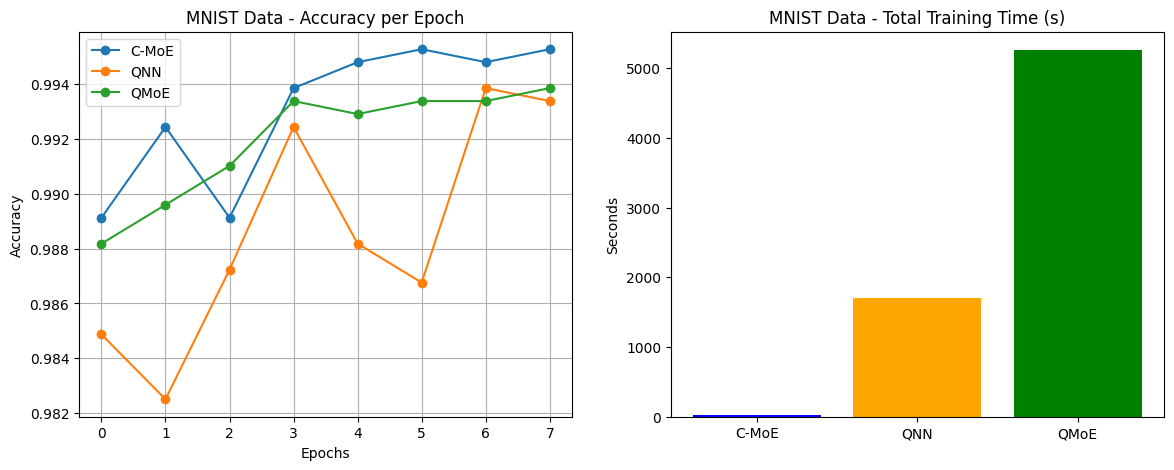

In [ ]:
def plot_results(results, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Accuracy
    for name, (hist, _) in results.items():
        ax1.plot(hist['acc'], label=name, marker='o')
    ax1.set_title(f"{title} - Accuracy per Epoch")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy")
    ax1.legend()
    ax1.grid(True)

    # Plot Time
    names = list(results.keys())
    times = [results[n][1] for n in names]
    ax2.bar(names, times, color=['blue', 'orange', 'green'])
    ax2.set_title(f"{title} - Total Training Time (s)")
    ax2.set_ylabel("Seconds")

    plt.show()

plot_results(results_syn, "Synthetic Data")
plot_results(results_mnist, "MNIST Data")